# Sketch Generation with Diffusion Models

This notebook demonstrates an approach for generating sketch drawings using a hybrid of Bidirectional RNNs and Diffusion Models, primarily inspired by **ChiroDiff: Modelling chirographic data with Diffusion Models**. The workflow covers dataset preparation, model architecture, training, inference, evaluation, and visualization. The implementation adapts ChiroDiff's approach for the QuickDraw dataset, targeting categories such as "cat", "bus", and "rabbit".

Key features include:
- Efficient handling of variable-length stroke sequences
- Bidirectional RNN architecture for capturing temporal dependencies in drawing sequences
- Quantitative evaluation with FID and KID metrics

# Imports

In [ ]:
# On Google Colab, you can install the required packages using pip.
%pip install torchmetrics[image]

In [62]:
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance
import torchvision.transforms as T
import numpy as np
from diffusers import DDIMScheduler
import json
import matplotlib.pyplot as plt
import random
from PIL import Image
import io
from IPython.display import display

# Configuration

Note: Dataset folders should be unzipped.

In [ ]:
# Dataset
data_dir = Path("data")
subset_dir = Path("subset")
category = "cat"

# Training
training_num_timesteps = 1000
training_max_moves = 256
num_epochs = 1000
batch_size = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inference
inference_num_timesteps = 50
inference_max_moves = 64
inference_num_samples = 4

Set seeds for reproducibility.

In [65]:
def set_seed(seed: int = 50) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Dataset

The dataset processing pipeline loads QuickDraw sketches for a specified category, filters samples using predefined indices, and converts each drawing into a sequence of normalized stroke deltas. Each stroke is represented by (dx, dy, pen_state), where coordinates are normalized to the canvas size and pen_state encodes stroke boundaries. Drawings are padded to a fixed length for batching, enabling efficient training and evaluation with variable-length sequences.

In [66]:
class QuickDrawDataset(Dataset):
    def __init__(
        self,
        category: str,
        data_dir: Path,
        subset_dir: Path,
        split="train",
        max_moves=256,
        canvas_size=256.0,
    ) -> None:
        self._max_moves = max_moves
        self._canvas_size = canvas_size

        self._data_path = data_dir / f"{category}.ndjson"
        self._indices_path = subset_dir / category / "indices.json"

        # Load subset indices
        with open(self._indices_path, "r") as f:
            indices = [int(i) for i in json.load(f)[split]]

        # Load all samples into memory and filter by indices
        all_samples = []
        with open(self._data_path, "r", encoding="utf-8") as f:
            for line in f:
                all_samples.append(json.loads(line))
        samples = [all_samples[i] for i in indices]

        self._drawings = []

        for sample in samples:
            strokes = sample["drawing"]  # List of [x_list, y_list]

            processed_strokes = []

            for stroke_idx, stroke in enumerate(strokes):
                x_list, y_list = stroke

                if len(x_list) != len(y_list) or len(x_list) < 2:
                    continue

                xs = np.array(x_list, dtype=np.float32)
                ys = np.array(y_list, dtype=np.float32)

                # Normalize points
                half_canvas = self._canvas_size / 2.0
                xs = (xs - half_canvas) / self._canvas_size
                ys = (ys - half_canvas) / self._canvas_size

                pen = np.ones_like(xs) * stroke_idx
                pen[-1] = stroke_idx + 1

                processed_stroke = np.stack([xs, ys, pen], axis=-1)
                processed_strokes.append(processed_stroke)

            # Concatenate all processed strokes and calculate diffs
            drawing = np.concatenate(processed_strokes, axis=0)
            drawing = np.diff(drawing, axis=0)
            drawing = drawing[: self._max_moves, :]

            self._drawings.append(drawing)

        samples.clear()

    def __len__(self) -> int:
        return len(self._drawings)

    def __getitem__(self, idx: int) -> dict:
        drawing = self._drawings[idx].copy()

        length = len(drawing)
        if length < self._max_moves:
            padding = np.zeros((self._max_moves - length, 3), dtype=np.float32)
            drawing = np.concatenate([drawing, padding], axis=0)

        return {
            "drawing": torch.from_numpy(drawing),  # (max_moves, 3)
            "length": torch.tensor(length, dtype=torch.long),
        }

# Dataset Visualization

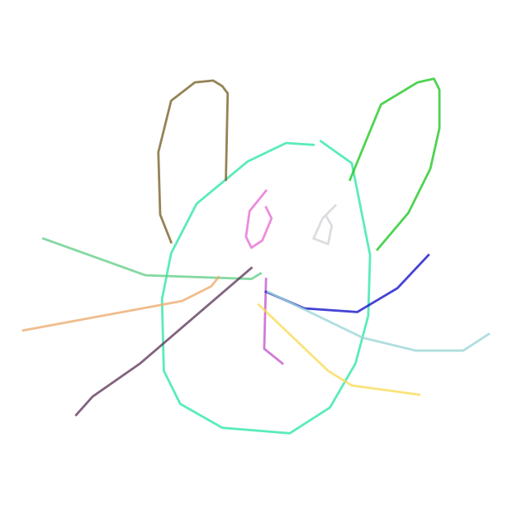

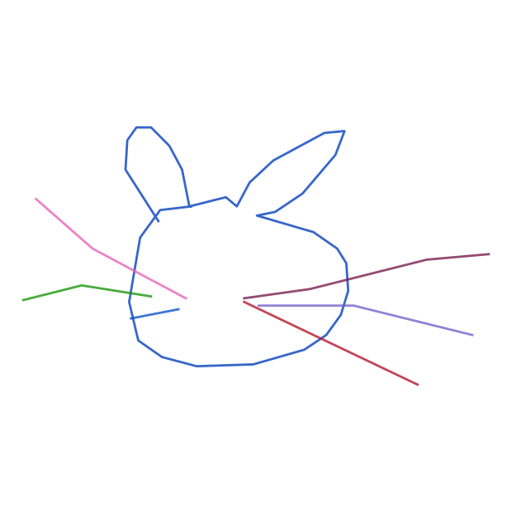

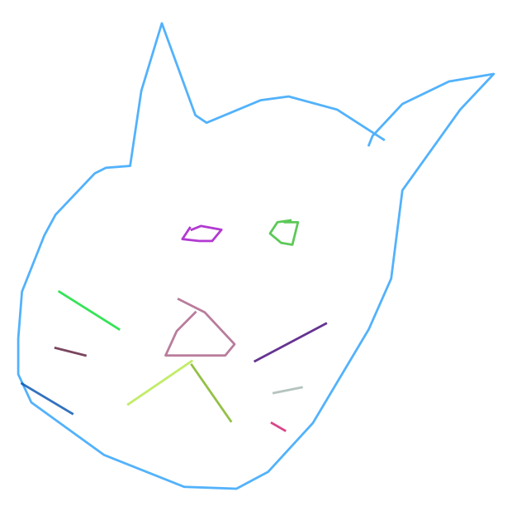

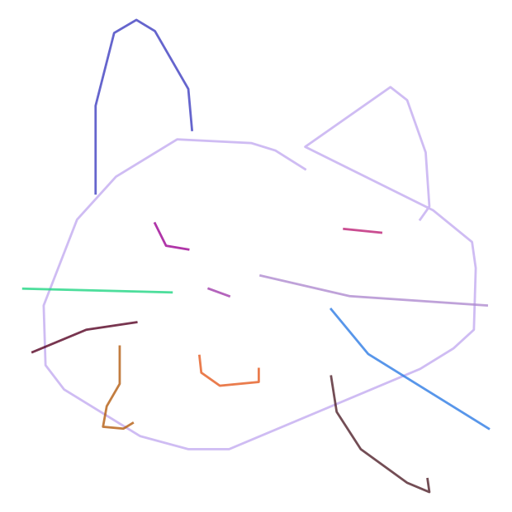

In [67]:
def plot_drawing(
    drawing: np.ndarray,
    random_stroke_colors=False,
    size=512,
) -> Image:
    length = drawing.shape[0]

    # Reconstruct absolute coordinates from deltas
    points = np.cumsum(drawing, axis=0)

    # Create a new figure
    fig = plt.figure(figsize=(8, 8))

    stroke_x = [0.0]
    stroke_y = [0.0]
    last_stroke_idx = 0
    new_stroke = False

    for point_idx, point in enumerate(points):
        x = point[0]
        y = point[1]
        stroke_idx = round(point[2])

        if new_stroke:
            stroke_x = [x]
            stroke_y = [y]
            last_stroke_idx = stroke_idx
            new_stroke = False
            continue

        stroke_x.append(x)
        stroke_y.append(y)

        if stroke_idx == last_stroke_idx + 1 or point_idx == length - 1:
            if random_stroke_colors:
                color = np.random.rand(3,)
            else:
                color = np.array([0.0, 0.0, 0.0])
            plt.plot(stroke_x, stroke_y, color=color, linewidth=2, alpha=0.8)
            new_stroke = True

    plt.gca().set_axis_off()
    plt.gca().invert_yaxis()
    plt.axis("equal")

    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    img = Image.open(buf).resize((size, size))

    plt.close(fig)

    return img


def plot_random_drawings_from_dataset():
    set_seed(64)

    # Load dataset
    dataset = QuickDrawDataset(
        category=category,
        data_dir=data_dir,
        subset_dir=subset_dir,
        split="train",
    )

    # Select random unique indices from the dataset
    num_samples = 4
    sample_indices = np.random.choice(len(dataset), size=num_samples, replace=False)

    for i in sample_indices:
        sample = dataset[i]
        drawing = sample["drawing"].numpy()
        length = sample["length"].item()
        drawing = drawing[:length]  # Trim to actual length
        image = plot_drawing(drawing, random_stroke_colors=True)
        display(image)

plot_random_drawings_from_dataset()

# Model Architecture

## Overview

This implementation uses a **Bidirectional RNN with Diffusion Model** approach for generating sketch drawings. The architecture is inspired by ChiroDiff and combines the sequential nature of drawing strokes with the power of diffusion models for high-quality generation.

## Key Components

### 1. Bidirectional GRU Network
- **Purpose**: Captures both forward and backward temporal dependencies in drawing sequences
- **Architecture**: 3-layer bidirectional GRU with 128 hidden units
- **Input Features**: 
  - Drawing deltas (dx, dy, pen_state): 3 dimensions
  - Absolute positions (x, y): 2 dimensions  
  - Time embeddings: 8 dimensions
  - **Total input size**: 13 dimensions

### 2. Time Embedding System
- **Fourier-based positional encoding** for diffusion timesteps
- Maps discrete timesteps (0-1000) to continuous 8-dimensional embeddings
- Enables the model to understand the denoising process stage

### 3. Drawing Representation
- **Delta encoding**: Stores relative movements (dx, dy) rather than absolute coordinates
- **Pen state**: Encodes stroke boundaries and pen up/down information
- **Sequence padding**: Handles variable-length drawings with masking

## Design Decisions

### Why Bidirectional RNN?
1. **Context awareness**: Future strokes provide context for current stroke prediction
2. **Stroke coherence**: Ensures generated strokes are consistent with overall drawing structure
3. **Better feature extraction**: Captures long-range dependencies in both directions

### Delta vs Absolute Coordinates
- **Delta encoding** is more efficient for stroke-based data
- Improves numerical stability
- Natural representation for pen movements

In [68]:
class BiRNN(nn.Module):
    _pe: torch.Tensor

    def __init__(
        self,
        n_input=3,  # (dx, dy, pen)
        n_output=3,  # (dx, dy, pen)
        n_hidden=128,
        n_layers=3,
        n_time_pe=8,
        n_timesteps=1000,
    ) -> None:
        super().__init__()

        self._init_time_embedding(n_time_pe, n_timesteps)

        n_rnn_input = n_input + 2 + n_time_pe  # +2 for absolute x, y positions
        self._rnn = nn.GRU(
            n_rnn_input,
            n_hidden,
            n_layers,
            batch_first=True,
            bidirectional=True,
        )
        self._rnn_proj = nn.Linear(n_hidden * 2, n_hidden)

        self._final_proj = nn.Linear(n_hidden + n_time_pe, n_output)

    def _init_time_embedding(self, n_time_pe: int, n_timesteps: int) -> None:
        fourier_scale=4.0

        fourier_proj_w = torch.randn(n_time_pe // 2, 1, requires_grad=False)

        ts = torch.linspace(1, n_timesteps, n_timesteps) / n_timesteps
        ts = ts[None, ...]

        proj = (fourier_proj_w * fourier_scale) @ ts
        emb = torch.cat(
            [torch.sin(2 * torch.pi * proj), torch.cos(2 * torch.pi * proj)], 0
        )
        pe = emb.T

        self.register_buffer("_pe", pe, persistent=True)

    def forward(
        self,
        drawings: torch.Tensor,
        lengths: torch.Tensor,
        timesteps: torch.Tensor,
    ) -> torch.Tensor:
        max_moves = drawings.shape[1]

        # Add absolute positions to the drawing
        positions = torch.cumsum(drawings[:, :, :2], dim=1)
        positions = torch.roll(positions, shifts=1, dims=1)
        positions[:, 0, :] = 0.0

        drawings_with_positions = torch.cat(
            [drawings, positions], dim=-1
        )  # (batch_size, max_moves, 5)

        # Encode time steps to get time embeddings
        time_pe = self._pe[timesteps, :]  # (batch_size, n_time_pe)

        # Expand to sequence length
        time_pe = time_pe.unsqueeze(1).repeat(
            1, max_moves, 1
        )  # (batch_size, max_moves, n_time_pe)

        rnn_input = torch.cat([drawings_with_positions, time_pe], dim=-1)
        rnn_input_packed = pack_padded_sequence(
            rnn_input, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        rnn_output, _ = self._rnn(rnn_input_packed)
        rnn_output_unpacked, _ = pad_packed_sequence(
            rnn_output,
            batch_first=True,
            total_length=max_moves,
        )
        rnn_proj_output: torch.Tensor = self._rnn_proj(rnn_output_unpacked)

        final_proj_output = self._final_proj(torch.cat([rnn_proj_output, time_pe], -1))
        return final_proj_output

# Training Procedure

## Overview
The training follows the standard diffusion model approach with specific adaptations for sequential drawing data.

## Training Process

### 1. Data Preparation
- Load QuickDraw dataset with category-specific drawings
- Convert absolute coordinates to delta (relative) movements
- Apply sequence padding to handle variable-length drawings
- Create masks for valid (non-padded) positions

### 2. Diffusion Training Loop
For each training step:

1. **Sample batch of drawings** from the dataset
2. **Add noise** to clean drawings using DDIM scheduler
   - Sample random timesteps
   - Add Gaussian noise
3. **Predict noise** using the BiRNN model
4. **Compute loss** with masking for valid sequence positions
5. **Backpropagate** and update model parameters

### 3. Key Training Features

#### Sequence Masking
- **Problem**: Variable-length drawings require padding
- **Solution**: Apply loss masking to ignore padded positions

#### Noise Scheduling
- **DDIM Scheduler**: More deterministic than DDPM, better for inference
- **1000 timesteps**: Provides fine-grained control over noise levels
- **Linear variance schedule**: Standard choice for diffusion models

#### Optimization
- **AdamW optimizer**: Better generalization than standard Adam
- **Batch size 512**: Large batches for stable gradient estimates
- **1000 epochs**: Sufficient for convergence on subset data

## Training Hyperparameters

| Parameter | Value |
|-----------|--------|
| Timesteps | 1000 |
| Max moves | 256 |
| Batch size | 512 |
| Epochs | 1000 |
| Learning rate | Default AdamW |

In [ ]:
set_seed()

# Model and scheduler
model = BiRNN().to(device)

scheduler = DDIMScheduler(training_num_timesteps)

# Dataset and dataloader
dataset = QuickDrawDataset(
    category=category,
    data_dir=data_dir,
    subset_dir=subset_dir,
    split="train",
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters())

# Training loop
model.train()
loss_fn = nn.MSELoss(reduction="none")  # Get per-element loss

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for batch in dataloader:
        drawings: torch.Tensor = batch["drawing"]
        lengths: torch.Tensor = batch["length"]

        drawings = drawings.to(device)
        lengths = lengths.to(device)

        batch_size = drawings.shape[0]
        max_len = drawings.shape[1]

        # Create mask for valid (non-padded) positions
        mask = torch.arange(max_len, device=device).unsqueeze(
            0
        ) < lengths.unsqueeze(1)
        mask = mask.unsqueeze(-1)  # Shape: (batch_size, max_len, 1)

        # Sample noise and timesteps
        noise = torch.randn_like(drawings)
        timesteps = torch.randint(
            0,
            training_num_timesteps,
            (batch_size,),
            device=device,
        ).long()

        # Add noise to clean moves
        noisy_moves = scheduler.add_noise(drawings, noise, timesteps)

        # Predict noise
        pred_noise: torch.Tensor = model(noisy_moves, lengths, timesteps)

        # Compute loss
        loss_unreduced: torch.Tensor = loss_fn(pred_noise, noise)
        masked_loss = loss_unreduced * mask
        num_valid_elements = mask.sum()
        loss = masked_loss.sum() / num_valid_elements

        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Print epoch statistics
    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch + 1} | Loss: {avg_loss:.4f}")

# Inference Procedure

## Overview
The inference process generates new drawings by starting from pure noise and iteratively denoising using the trained model.

## Inference Process

### 1. Initialization
- **Start with pure Gaussian noise**
- **Set inference timesteps**: Reduced to 50 steps (vs 1000 training steps)
- **Configure scheduler**: DDIM with deterministic sampling

### 2. Iterative Denoising
For each timestep t from T to 0:

1. **Prepare current state**: Noisy drawing at timestep t
2. **Model prediction**: Predict noise
3. **Scheduler step**: Compute x_{t-1} using DDIM update rule
4. **Continue**: Until reaching clean sample x_0

### 3. Post-processing
- **Convert to numpy**: Move from GPU to CPU
- **Binarize pen states**: Convert continuous values to discrete pen up/down
- **Reconstruct absolute coordinates**: Convert deltas to absolute positions for visualization

## Key Inference Features

### Accelerated Sampling
- **50 vs 1000 steps**: 20x faster inference
- **DDIM deterministic**: More predictable results than stochastic DDPM

### Sequence Length Control
- **Max moves 64**: Shorter sequences for faster and better generation
- **Full length assumption**: Model uses maximum length during generation

### Pen State Processing
- **Threshold 0.8**: Convert continuous pen predictions to binary
- **Stroke separation**: Maintains drawing structure and stroke boundaries

## Generation Parameters

| Parameter | Training | Inference |
|-----------|----------|-----------|
| Timesteps | 1000 | 50 |
| Max moves | 256 | 64 |
| Batch size | 512 | 1 |

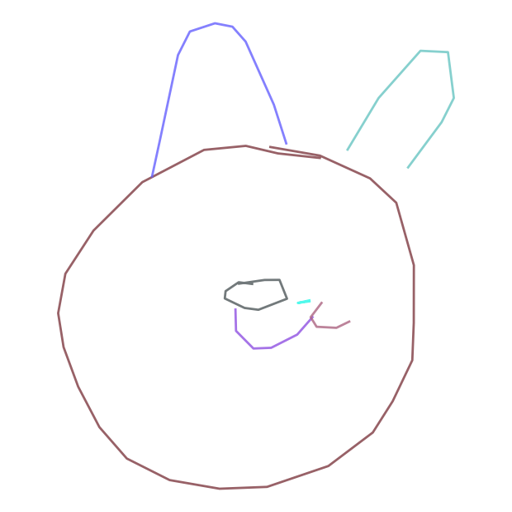

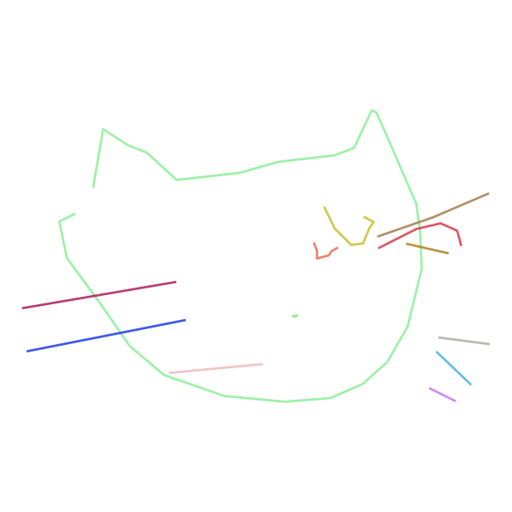

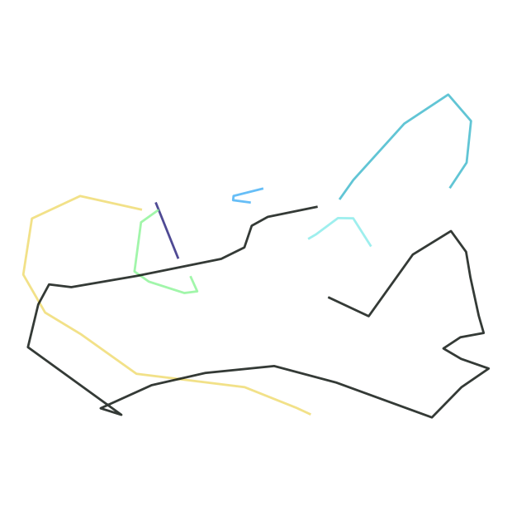

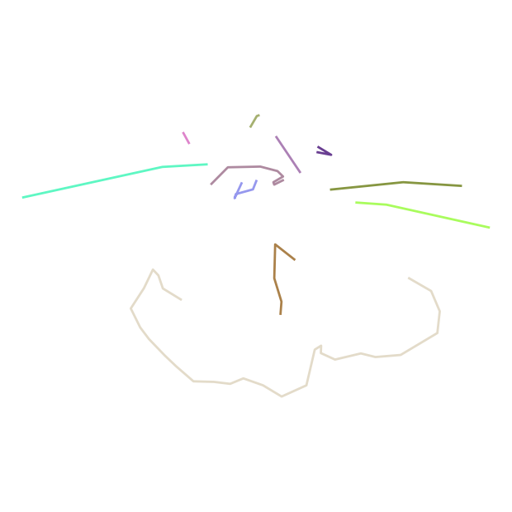

In [71]:
def generate_drawing(
    model: BiRNN,
    scheduler: DDIMScheduler,
    device: torch.device,
    max_moves: int,
    num_inference_steps: int,
) -> np.ndarray:
    model.eval()

    with torch.no_grad():
        # Start with pure noise
        drawing = torch.randn(1, max_moves, 3, device=device)

        # Set up the scheduler for inference
        scheduler.set_timesteps(num_inference_steps)

        # Denoising loop
        for t in scheduler.timesteps:
            # Prepare timestep
            timestep_batch = torch.full((1,), t, device=device, dtype=torch.long)

            # Predict noise
            with torch.no_grad():
                # Use full length for generation
                lengths = torch.tensor([max_moves], device=device)
                noise_pred = model(drawing, lengths, timestep_batch)

            # Compute the previous noisy sample
            drawing = scheduler.step(noise_pred, t, drawing).prev_sample

    # Convert to numpy and determine actual length
    drawing_np = drawing[0].cpu().numpy()

    # Convert pen state to binary
    drawing_np[:, 2] = np.where(drawing_np[:, 2] > 0.8, 1.0, 0.0)

    return drawing_np

set_seed()

# Generate multiple drawings
for i in range(inference_num_samples):
    # Generate drawing
    drawing = generate_drawing(
        model=model,
        scheduler=scheduler,
        device=device,
        max_moves=inference_max_moves,
        num_inference_steps=inference_num_timesteps,
    )

    # Plot the generated drawing
    image = plot_drawing(drawing, random_stroke_colors=True)
    display(image)

# Evaluation

### Performance by Category
- **Bus (FID: 13.0)**: Best performance - simpler geometric shapes
- **Cat (FID: 20.1)**: Moderate performance - organic but recognizable forms  
- **Rabbit (FID: 20.5)**: Challenging - complex organic shapes with details

**Note**: The FID and KID metrics used here might not be entirely accurate for sketch evaluation, as the underlying Inception network was trained on natural images rather than sketch data. This could lead to less reliable similarity assessments between real and generated sketches.

### Cat:

FID: 20.092737197875977

KID: 0.007985197938978672 ± 1.6307721750763449e-07

### Bus:

FID: 13.001677513122559

KID: 0.002443628152832389 ± 1.4258183966830984e-07

### Rabbit:

FID: 20.462812423706055

KID: 0.006181297358125448 ± 1.435505367908263e-07


In [72]:
transform = T.Compose([
    T.Resize(299),
    T.ToTensor()
])


def get_real_images() -> torch.Tensor:
    dataset = QuickDrawDataset(
        category=category,
        data_dir=data_dir,
        subset_dir=subset_dir,
        split="test",
    )

    images = []

    for i in range(100):
        sample = dataset[i]
        drawing = sample["drawing"].numpy()
        length = sample["length"].item()
        drawing = drawing[:length]
        image = plot_drawing(drawing, random_stroke_colors=False)
        images.append(transform(image.convert("RGB")).to(torch.uint8))

    return torch.stack(images).to(device)


def get_generated_images() -> torch.Tensor:
    set_seed()

    images = []

    for i in range(100):
        drawing = generate_drawing(
            model=model,
            scheduler=scheduler,
            device=device,
            max_moves=inference_max_moves,
            num_inference_steps=inference_num_timesteps,
        )
        image = plot_drawing(drawing, random_stroke_colors=False)
        images.append(transform(image.convert("RGB")).to(torch.uint8))

    return torch.stack(images).to(device)


real_images = get_real_images()
generated_images = get_generated_images()

fid = FrechetInceptionDistance(feature=2048).to(device)
kid = KernelInceptionDistance(subset_size=100, feature=2048).to(device)

fid.update(real_images, real=True)
fid.update(generated_images, real=False)
fid_score = fid.compute()

kid.update(real_images, real=True)
kid.update(generated_images, real=False)
kid_mean, kid_std = kid.compute()

print(f"FID: {fid_score}")
print(f"KID: {kid_mean} ± {kid_std}")

FID: 20.092737197875977
KID: 0.007985197938978672 ± 1.6307721750763449e-07


# Create GIF

In [73]:
def create_gif(drawing: np.ndarray, file_path: Path, fps=10, size=512):
    frames = []
    for i in range(len(drawing)):
        image = plot_drawing(drawing[:i], random_stroke_colors=False, size=size)
        frames.append(image)

    frames[0].save(
        file_path,
        save_all=True,
        append_images=frames[1:],
        optimize=False,
        duration=1000 // fps,
        loop=0,
    )

set_seed()

drawing = generate_drawing(
    model=model,
    scheduler=scheduler,
    device=device,
    max_moves=inference_max_moves,
    num_inference_steps=inference_num_timesteps,
)

file_path = Path(f"{category}_drawing_animation.gif")

create_gif(drawing, file_path=file_path)

# Current Limitations

- **Large coordinate jumps**: The current processing can result in large jumps between consecutive points, which may affect stroke smoothness
- **Limited data augmentation**: No noise injection or other augmentation techniques to improve model robustness
- **Inception network mismatch**: FID and KID metrics use an Inception network trained on natural images, not sketches, leading to potentially unreliable evaluation

# Potential Improvements

- **Equispaced resampling**: Implement equispaced resampling in the dataset processing to avoid large jumps between consecutive points and ensure smoother stroke representation
- **Add jitter noise**: Introduce jitter noise to the dataset during training to improve model robustness and generalization to variations in drawing styles
- **Stroke normalization**: Apply consistent stroke-level normalization to improve training stability
- **Train Inception on sketch images**: Develop or fine-tune an Inception network specifically on sketch data to calculate FID and KID metrics more accurately for sketch generation tasks


# References

[ChiroDiff: Modelling chirographic data with Diffusion Models
](https://arxiv.org/abs/2304.03785)

[A Neural Representation of Sketch Drawings
](https://arxiv.org/abs/1704.03477)